In [1]:
import openmeteo_requests as omr
import pandas as pd 
import requests_cache
from retry_requests import retry
from geopy.geocoders import Nominatim
import numpy as np
import os 
from notionai import NotionAI
token = os.getenv("")

#OpenAI.__init__(apikey



In [ ]:
#ai= NotionAI(##token)
#response= ai.writing_with_prompt("write about the weather")
#print(response)
from notionai import NotionAI
#token = os.getenv(
#spaces= NotionAI.get_spaces(token)

In [7]:

def getcoordinates(userlocation):
    """add docstring"""
    geolocator=Nominatim(user_agent="Dress for the Weather")
    location=geolocator.geocode(userlocation)
    coordinates=[location.latitude, location.longitude]
    #print(coordinates) # CH don't use print inside the function, print the return
    return coordinates
 

In [8]:
# test getcoordinates function
location = "Seattle, WA"
lat, lon = getcoordinates(location)
print(f"{location}: Latitude: {lat}, Longitude: {lon}")

Seattle, WA: Latitude: 47.6038321, Longitude: -122.330062


In [11]:
def getweather(lat, lon): # get weather data for given lat, lon
    cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = omr.Client(session = retry_session)

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "temperature_2m", 
        "forecast_days": 1,
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch",
        "current": ["temperature_2m"],
        "timezone": "auto", # needed for local time conversion
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation: {response.Elevation()} m asl")
    print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")
    #get rid of print statements
    # You could also return elevation and timezone difference if needed

    # Process hourly data. The order of variables needs to be the same as requested.
    current = response.Current()
    current_temperature_2m = current.Variables(0).Value()

    # Access hourly temperature data (1D numpy array)
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

    # You can also get the hourly timestamps (secs since Jan 1, 1970)
    hourly_time = hourly.Time()
    hourly_time_end = hourly.TimeEnd()

    #
    # Create a pandas DataFrame with the hourly data
    #

    # Get the timezone offset for this location
    timezone_offset_seconds = response.UtcOffsetSeconds()
    
    # Convert Unix timestamps to UTC datetime objects first
    start_time_utc = pd.to_datetime(hourly_time, unit="s")
    end_time_utc = pd.to_datetime(hourly_time_end, unit="s")
    
    #  Convert to local time by adding the timezone offset
    start_time_local = start_time_utc + pd.Timedelta(seconds=timezone_offset_seconds)
    end_time_local = end_time_utc + pd.Timedelta(seconds=timezone_offset_seconds)
    
    # Get the interval between data points (usually 3600 seconds = 1 hour)
    interval_seconds = hourly.Interval()
    time_step = pd.Timedelta(seconds=interval_seconds)
    
    # Create a range of dates from start to end with the given interval (in local time)
    date_range_local = pd.date_range(
        start=start_time_local,
        end=end_time_local,
        freq=time_step,
        inclusive="left"  # Don't include the end time
    )
    
    # Extract just the hour from the datetime objects
    hours_only = date_range_local.strftime('%H:%S')  # Format as HH:MM (e.g., "14:00")
    
    # Get the current date (using the first timestamp)
    current_date = date_range_local[0].date()
    
    # Create the dictionary for the DataFrame
    hourly_data = {
        "hour": hours_only,
        "temperature_2m": hourly_temperature_2m
    }
    
    # Create the DataFrame
    hourly_dataframe = pd.DataFrame(data=hourly_data)

    return round(current_temperature_2m, 1), hourly_dataframe, current_date


In [12]:
# test getweather
current_temp, df, current_date = getweather(lat, lon)
print(f"Current Temperature in {location}: {current_temp}°F")
print(f"Current Date: {current_date}")

Coordinates: 47.59556198120117°N -122.32443237304688°E
Elevation: 40.0 m asl
Timezone difference to GMT+0: -25200s
Current Temperature in Seattle, WA: 57.8°F
Current Date: 2025-10-23


In [13]:

# CH it's better to return strings from functions rather than print them directly
# E.g. if this would be inside a web app, you would want to return the string to be displayed on the webpage
def weather(temperature):
    if temperature > 80:
        return "Shorts and a t-shirt"
    elif 60 <= temperature <= 70:
        return "Shorts and a t-shirt or a light jacket"
    elif 50 <= temperature < 60:
        return "pants and a longsleeve"
    elif 40 <= temperature < 50:
        return "pants and a longsleeve with a light jacket"

In [14]:
# test weather using current_temp
print(f"Recommended clothing for {current_temp}°F: {weather(current_temp)}")

Recommended clothing for 57.8°F: pants and a longsleeve


In [15]:
# print out the dataframe with hourly data and the current date
def print_hourly_dataframe(dataframe, current_date):
    print(f"Hourly Temperature Data for {current_date}:")
    print(dataframe.head())


In [19]:
# plot dataframe 
import matplotlib.pyplot as plt

def plot_hourly_temperature2(dataframe, current_date):

    # create a figure
    plot = plt.figure()
     
    # plot dataframe['hour'] (x) vs dataframe['temperature_2m'] (y)
    plt.plot(dataframe['hour'], dataframe['temperature_2m'], marker='o')
    
    # show current date in title
    plt.title(current_date)

    # label x (Hours) and y (Temperature (°F)) axis
    plt.xlabel("Hours")
    plt.ylabel("Temperature F")

    # rotate x-axis labels for better readability by 45 degrees
    plt.xticks(rotation=45)

    # add a grid
    plt.grid()

    # show the plot
    plt.show()

Coordinates: 42.02252197265625°N -93.62749481201172°E
Elevation: 285.0 m asl
Timezone difference to GMT+0: -18000s
Current Temperature in Ames, Iowa: 53.1°F
Recommended clothing for 53.1°F: pants and a longsleeve


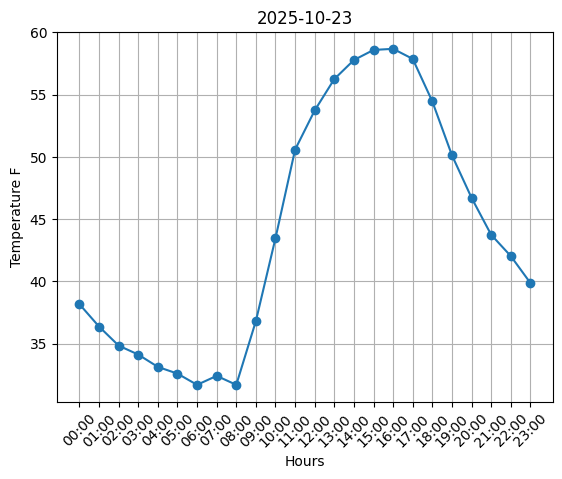

In [20]:
# MAIN part of the script
done = False
while not done:

    location = input("Enter your location: ")
    lat, lon = getcoordinates(location)
    current_temp, df, current_date = getweather(lat, lon)
    print(f"Current Temperature in {location}: {current_temp}°F")   
    print(f"Recommended clothing for {current_temp}°F: {weather(current_temp)}")
    #print_hourly_dataframe(df, current_date)
    plot_hourly_temperature2(df, current_date)
    again = input("Would you like to check another location? (y/n): ")
    if again.lower() != 'y':
        done = True

    

In [ ]:
# plot dataframe 
import matplotlib.pyplot as plt

def plot_hourly_temperature(dataframe, current_date):

    # create a figure
    plt.figure(figsize=(10, 5)) 
    # plot dataframe['hour'] (x) vs dataframe['temperature_2m'] (y)
    plt.plot(dataframe['hour'], dataframe['temperature_2m'], marker='o')  
    # show current date in title
    plt.title(f'Hourly Temperature on {current_date}')
    # label x (Hours) and y (Temperature (°F)) axis
    plt.xlabel('Hour')
    plt.ylabel('Temperature (°F)')
    # rotate x-axis labels for better readability by 45 degrees
    plt.xticks(rotation=45)
    # add a grid
    plt.grid()
    #plt.tight_layout()
    # show the plot
    plt.show()